# Br41n.io hackaton

Data visualization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mne

from scipy.io import loadmat
from mne.io import RawArray
from mne import create_info
from mne.time_frequency import psd_welch

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    StandardScaler,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier

import joblib

%gui qt
%matplotlib qt

In [2]:
CH_TO_KEEP = ['Cz', 'FC2', 'CP2', 'C4', 'FC6', 'CP6', 'T8']
CH_TO_KEEP_INDEX = [41, 43, 45, 47, 49, 53, 55]

CH_NAMES = mne.channels.make_standard_montage('biosemi64').ch_names

## initialisation of the variables

In [3]:
def load_data(filename):
    s01 = loadmat(filename)
    eeg_data = s01['eeg']
    value = eeg_data[0,0]

    srate = value['srate'][0,0]
    n_trials = value['n_imagery_trials'][0,0]

    bad_trials = value['bad_trial_indices']
    event_onset = value['imagery_event'][0]
    senloc = value['senloc']

    rest_signal = value['rest']
    imagery_left = value['imagery_left']

    npnts = len(imagery_left[0])
    timevec = np.arange(0, npnts)/srate    
    
    return imagery_left,timevec,srate,event_onset,senloc

## mne object creation

In [4]:
def create_raw(eeg_data, electrodes_position):
    raw_array = RawArray(imagery_left[CH_TO_KEEP_INDEX], info=create_info(sfreq=srate, ch_types='eeg', ch_names=CH_TO_KEEP))

    montage = {key:value for key, value in zip(CH_NAMES, electrodes_position)}
    raw_array.set_montage(mne.channels.make_dig_montage(montage))

    raw_array.notch_filter(60)
    raw_array.filter(0.5, 60)
    
    return raw_array

## Adding annotations

In [5]:
def set_annotations(raw_array, event_onset, timevec):
    actif_onset_index = np.where(event_onset == 1)
    actif_onsets = timevec[actif_onset_index]
    actif_duration = 3
    actif_description = 'Actif'

    repos_onsets = actif_onsets + actif_duration
    repos_duration = 4
    repos_description = 'Repos'

    onsets = np.concatenate((actif_onsets, repos_onsets))
    onsets = np.sort(onsets)

    durations = []
    descriptions = []
    for i in range(0, int(len(onsets)/2)):
        durations.append(actif_duration)
        descriptions.append(actif_description)

        durations.append(repos_duration)
        descriptions.append(repos_description)

    annotations = mne.Annotations(onsets, durations, descriptions)
    raw_array.set_annotations(annotations)
    
    return raw_array

## Epoching

In [6]:
def create_epochs(raw_array, srate):
    event_id = {'Repos':0, 'Actif':1}
    events, annot_event_id = mne.events_from_annotations(raw_array, event_id=event_id, chunk_duration=1)
    epochs = mne.Epochs(raw=raw_array, events=events, event_id=event_id, tmin=0, tmax=1-(1/srate), preload=True, baseline=None, verbose=False)
    y = events[:,2]
    return epochs, y

## Spectrogram

In [7]:
FREQ_BANDS_RANGE = {
    'DELTA': [0.5, 4.5],
    'THETA': [4.5, 8.5],
    'ALPHA': [8.5, 11.5],
    'SIGMA': [11.5, 15.5],
    'BETA': [15.5, 30]
}

def get_psds_from_epochs(epochs):
    """Extracts power spectrum densities from epochs
    Returns
    --------
    psds with associated frequencies calculated with the welch method.
    """
    psds, freqs = psd_welch(epochs, fmin=0.5, fmax=30.)
    return psds, freqs

def get_mean_psds(psds_with_freqs, are_relative=False):
    """EEG power band feature extraction.
    Input
    -------
    psds_with_freqs: tuple which contains
            - (nb_epochs, nb_chan=1, nb_freqs) psds amplitudes
            - (nb_freqs,) corresponding frequency values
            
    are_relative: boolean which indicates if the mean band powers
        for each subband are relative to the total power or not.
    
    Returns
    -------
    X : numpy array of shape [n_samples, nb_subband=5]
        Transformed data.
    """
    psds = psds_with_freqs[0]
    freqs = psds_with_freqs[1]
    
    if are_relative:
        psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS_RANGE.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

frequency_domain_pipeline = Pipeline([
    ('get_psds_from_epochs', FunctionTransformer(get_psds_from_epochs, validate=False)),
    ('frequency_domain_features', FunctionTransformer(get_mean_psds, validate=False))
])

## Run on many files


In [8]:
filenames = ['dataset/s01.mat', 'dataset/s02.mat', 'dataset/s03.mat', 'dataset/s04.mat', 'dataset/s05.mat', 'dataset/s06.mat']

features = []
labels = []
groups = []

for index, filename in enumerate(filenames):
    imagery_left, timevec, srate, event_onset, senloc = load_data(filename)
    imagery_left_raw = create_raw(imagery_left, senloc)
    imagery_left_raw = set_annotations(imagery_left_raw, event_onset, timevec)
    imagery_left_epochs, y = create_epochs(imagery_left_raw, srate)
    
    features.append(frequency_domain_pipeline.transform(imagery_left_epochs))
    labels.append(y)
    groups.append(np.repeat(index, features[-1].shape[0]))


features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)
groups = np.concatenate(groups, axis=0)

Creating RawArray with float64 data, n_channels=7, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3379 samples (6.600 sec)



<ipython-input-4-2054de3508dd>:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_array.set_montage(mne.channels.make_dig_montage(montage))


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 3379 samples (6.600 sec)

Used Annotations descriptions: ['Actif', 'Repos']


<ipython-input-5-97290386f970>:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_array.set_annotations(annotations)


Effective window size : 0.500 (s)
Creating RawArray with float64 data, n_channels=7, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3379 samples (6.600 sec)



<ipython-input-4-2054de3508dd>:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_array.set_montage(mne.channels.make_dig_montage(montage))


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 3379 samples (6.600 sec)

Used Annotations descriptions: ['Actif', 'Repos']


<ipython-input-5-97290386f970>:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_array.set_annotations(annotations)


Effective window size : 0.500 (s)
Creating RawArray with float64 data, n_channels=7, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3379 samples (6.600 sec)



<ipython-input-4-2054de3508dd>:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_array.set_montage(mne.channels.make_dig_montage(montage))


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 3379 samples (6.600 sec)

Used Annotations descriptions: ['Actif', 'Repos']


<ipython-input-5-97290386f970>:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_array.set_annotations(annotations)


Effective window size : 0.500 (s)
Creating RawArray with float64 data, n_channels=7, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuat

<ipython-input-4-2054de3508dd>:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_array.set_montage(mne.channels.make_dig_montage(montage))


- Filter length: 3379 samples (6.600 sec)

Used Annotations descriptions: ['Actif', 'Repos']


<ipython-input-5-97290386f970>:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_array.set_annotations(annotations)


Effective window size : 0.500 (s)
Creating RawArray with float64 data, n_channels=7, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 60 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuat

<ipython-input-4-2054de3508dd>:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_array.set_montage(mne.channels.make_dig_montage(montage))



Used Annotations descriptions: ['Actif', 'Repos']


<ipython-input-5-97290386f970>:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_array.set_annotations(annotations)


Effective window size : 0.500 (s)
Creating RawArray with float64 data, n_channels=7, n_times=358400
    Range : 0 ... 358399 =      0.000 ...   699.998 secs
Ready.
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3379 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 60 Hz

FIR filter parameters
---------------------


<ipython-input-4-2054de3508dd>:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_array.set_montage(mne.channels.make_dig_montage(montage))


Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 60.00 Hz
- Upper transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 67.50 Hz)
- Filter length: 3379 samples (6.600 sec)

Used Annotations descriptions: ['Actif', 'Repos']


<ipython-input-5-97290386f970>:24: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_array.set_annotations(annotations)


Effective window size : 0.500 (s)


## Entrainement d'un modele avec les bandes de frequences pour les differents channels

### KNN

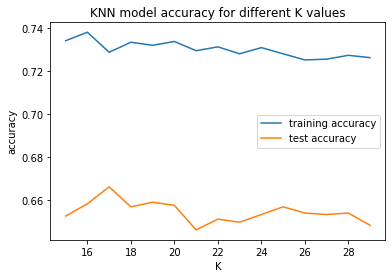

In [9]:
# Ces listes vont nous permettrent par la suite de visualiser l'evolution de la precision des modeles par rapport a leur
# complexite pour les classificateurs.
training_accuracy_clf = []
test_accuracy_clf = []

# X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels, random_state=66)

shuffle_split = GroupShuffleSplit(n_splits=2, train_size=.7, random_state=42)
train_idx, test_idx = next(shuffle_split.split(features, labels, groups=groups))
X_train, X_test, y_train, y_test = features[train_idx], features[test_idx], labels[train_idx], labels[test_idx]

neighbors_settings = range(15, 30)

for n_neighbors in neighbors_settings:
    clf = Pipeline([
        ('std_scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=n_neighbors)),
    ])
    clf.fit(X_train, y_train) # on l'entraine
    training_accuracy_clf.append(clf.score(X_train, y_train)) # on ajoute la precision selon le train_set a la liste
    test_accuracy_clf.append(clf.score(X_test, y_test)) # on ajoute la precision selon le test_set a la liste

plt.plot(neighbors_settings, training_accuracy_clf, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy_clf, label="test accuracy")
plt.title("KNN model accuracy for different K values")
plt.xlabel("K")
plt.ylabel("accuracy")
plt.legend()

In [10]:
y_train

array([1, 1, 1, ..., 1, 0, 0])

In [11]:
np.unique(groups[train_idx]), np.unique(groups[test_idx])

(array([2, 3, 4, 5]), array([0, 1]))

## Random forest

In [14]:
# Split randomly
# X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify=labels, random_state=0)

# Split according to subject (test contains new subject)
shuffle_split = GroupShuffleSplit(n_splits=2, train_size=.7, random_state=42)
train_idx, test_idx = next(shuffle_split.split(features, labels, groups=groups))
X_train, X_test, y_train, y_test = features[train_idx], features[test_idx], labels[train_idx], labels[test_idx]

# forest = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=10).fit(X_train, y_train)

forest = Pipeline([
    ('std_scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=800, random_state=0, max_depth=20, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', bootstrap=False)),
]).fit(X_train, y_train)

print(forest.score(X_train, y_train))
print(forest.score(X_test, y_test))


1.0
0.6826647564469914


In [15]:
joblib.dump(forest, 'models/rf.joblib')

['models/rf.joblib']

## ameliorations
- a la place d'utiliser des epochs de 1 secondes en prendre de 3 secondes